Random Forest Classification Using Ghost, WALLET, MINER and RISCV Dataset
Accuracy: 98%

In [7]:
import re
import os
import pandas as pd
# import csv

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_pickle("ghost_wallet_synthetic.pkl")
df

,filename,filepath,label,code
0,ALU_RV32I.v,dataset_synthetic\TjFree\ALU_RV32I.v,0,module alu_rv32i #(parameter n = 32) (input [n...
1,bip39.v,dataset_synthetic\TjFree\bip39.v,0,"module bip39 ( input i_clk, input i_reset_n, i..."
2,Branch_CTLR.v,dataset_synthetic\TjFree\Branch_CTLR.v,0,"module branch_ctlr (input [2:0] branch_in, inp..."
3,crypto_wallet2_top.v,dataset_synthetic\TjFree\crypto_wallet2_top.v,0,"module crypto_wallet2_top ( input clock_50, ou..."
4,CTLR_Unit_RV32I.v,dataset_synthetic\TjFree\CTLR_Unit_RV32I.v,0,"module ctlr_unit_rv32i (input [6:0] op_code, f..."
...,...,...,...,...
1043,sram_HT3_models_gemini-1.5-pro-latest_A1_clean...,GHOST_benchmarks-main\TjIn\sram_HT3_models_gem...,1,"module sram_32x128_1rw ( clk0, csb0, web0, add..."
1044,uart_rx_HT1_gpt-4_A1_cleaned.v,GHOST_benchmarks-main\TjIn\uart_rx_HT1_gpt-4_A...,1,"module uart_rx( input wire clk , input wire re..."
1045,uart_rx_HT1_models_gemini-1.5-pro-latest_A1_cl...,GHOST_benchmarks-main\TjIn\uart_rx_HT1_models_...,1,"module uart_rx( input wire clk , input wire re..."
1046,uart_rx_HT2_gpt-4_A1_cleaned.v,GHOST_benchmarks-main\TjIn\uart_rx_HT2_gpt-4_A...,1,"module uart_rx( input wire te, input wire clk,..."


In [3]:
X_raw = df['code']
y = df['label']

In [4]:
# Step 4: TF-IDF Vectorization with N-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000, stop_words=['module','endmodule','input','output','wire','assign','reg','always','begin','end'])
X = vectorizer.fit_transform(X_raw)

# Step 5: Resample with SMOTE
smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [5]:
# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],              
    'max_depth': [None, 10, 20, 30, 40, 50],                            
    'max_features': ['sqrt', 'log2', None] 
}


grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

best_params = {'max_depth': None, 'max_features': None, 'n_estimators': 300}

# Step 8: Evaluate Model
y_pred = grid.predict(X_test)
print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': None, 'max_features': None, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       288
           1       0.99      0.97      0.98       321

    accuracy                           0.98       609
   macro avg       0.98      0.98      0.98       609
weighted avg       0.98      0.98      0.98       609



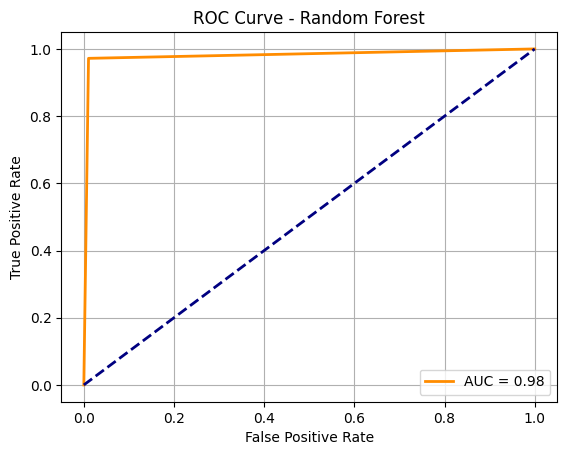

In [9]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()